In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import os
import json
import pickle
from ray.rllib.utils.replay_buffers import MultiAgentPrioritizedReplayBuffer

/home/seventheli/conda/envs/hpc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create a color palette
palette = sns.color_palette("muted", 4)

# Create a dictionary that maps each unique value to a color
palette_dict = dict(zip([32, 128, 512, 2048], palette))


In [13]:
# {i:{} for i in os.listdir("/home/seventheli/JADE_checkpoints/")}

In [22]:
experiments = {
    'Boxing': {},
    'Defender': {},
    'Frostbite': {},
    'Asterix': {},
    'FishingDerby': {},
    'Asteroids': {},
    'BeamRider': {},
    'Carnival': {},
    'Amidar': {},
    'Freeway': {},
    'Assault': {},
    'SpaceInvaders': {},
    'BankHeist': {},
    'Berzerk': {},
    'Bowling': {},
    'BattleZone': {},
    'Atlantis': {},
    'Gopher': {},
    'CrazyClimber': {},
    'Centipede': {},
    'Qbert': {},
    'Breakout': {},
    'Alien': {},
    'ChopperCommand': {}}

configs = {
    'Boxing': {},
    'Defender': {},
    'Frostbite': {},
    'Asterix': {},
    'FishingDerby': {},
    'Asteroids': {},
    'BeamRider': {},
    'Carnival': {},
    'Amidar': {},
    'Freeway': {},
    'Assault': {},
    'SpaceInvaders': {},
    'BankHeist': {},
    'Berzerk': {},
    'Bowling': {},
    'BattleZone': {},
    'Atlantis': {},
    'Gopher': {},
    'CrazyClimber': {},
    'Centipede': {},
    'Qbert': {},
    'Breakout': {},
    'Alien': {},
    'ChopperCommand': {}}


In [23]:
for each in experiments.keys():
    path = os.path.join("/home/seventheli/motivation_frames/logging", each)
    config = os.path.join("/home/seventheli/motivation_frames/checkpoints", each)
    if os.path.exists(path):
        for experiment in os.listdir(path):
            location = os.path.join(path, experiment)
            config_location = os.path.join(config, experiment)
            if len(os.listdir(location)) <= 5:
                print("<= 5: %s, %d" % (location, len(os.listdir(location))))
            else:
                if os.path.exists(os.path.join(config_location, experiment + "_config.pyl")):
                    with open(os.path.join(config_location, experiment + "_config.pyl"), "rb") as f:
                        configs[each][experiment] = pickle.load(f)
                    experiments[each][experiment] = []
                    for file in os.listdir(location):
                        try:
                            with open(os.path.join(location, file), "r") as f:
                                experiments[each][experiment].append(json.load(f))
                        except:
                            print("error code: %s " % file)
                else:
                    print("config not existing %s" % experiment)

<= 5: /home/seventheli/motivation_frames/logging/SpaceInvaders/.ipynb_checkpoints, 0


In [24]:
selected = {
    'Boxing': [],
    'Defender': [],
    'Frostbite': [],
    'Asterix': [],
    'FishingDerby': [],
    'Asteroids': [],
    'BeamRider': [],
    'Carnival': [],
    'Amidar': [],
    'Freeway': [],
    'Assault': [],
    'SpaceInvaders': [],
    'BankHeist': [],
    'Berzerk': [],
    'Bowling': [],
    'BattleZone': [],
    'Atlantis': [],
    'Gopher': [],
    'CrazyClimber': [],
    'Centipede': [],
    'Qbert': [],
    'Breakout': [],
    'Alien': [],
    'ChopperCommand': []
}

In [25]:
for games in configs.keys():
    for experiment in configs[games]:
        _config = configs[games][experiment]
        if _config["replay_buffer_config"]["type"] == MultiAgentPrioritizedReplayBuffer and experiment[0:4] == "APEX":
            selected[games].append([experiment, _config["train_batch_size"]])

In [26]:
sampler = {}
tags = ["episode_reward_max", "episode_reward_min", "episode_reward_mean", "episodes_this_iter"]

for each in selected.keys():
    _experiments = []
    for select in selected[each]:
        steps = []
        for info in experiments[each][select[0]]:
            _info = {
                **{i: info["sampler_results"][i] for i in tags},
                **info["counters"],
                **info["timers"],
                **{
                    "episodes_total": info["episodes_total"],
                    "training_iteration": info["training_iteration"],
                    "time_this_iter_s": info["time_this_iter_s"],
                    "time_total_s": info["time_total_s"]
                }
            }
            steps.append(_info)
        steps = pd.DataFrame(steps).sort_values("time_total_s")
        steps["bz"] = select[1]
        steps["exp"] = select[0]
        steps["env"] = each.replace("NoFrameskip-v4", "")
        _experiments.append(steps)
    if _experiments:
        sampler[each] = pd.concat(_experiments)

sampler = {key: sampler[key] for key in sorted(sampler)}

In [27]:
pd.concat([i[1].copy() for i in sampler.items()]).to_csv("./ana_apex.csv", index=False)

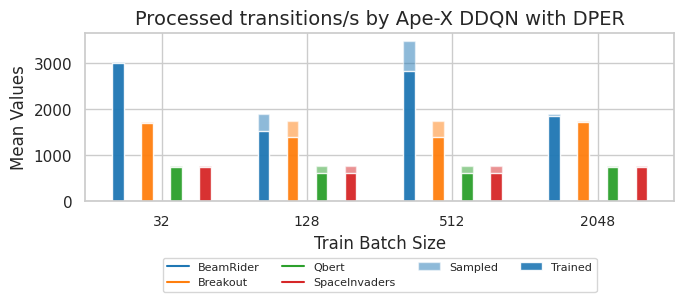

In [30]:
summary_image = pd.concat([i[1].copy() for i in sampler.items()])
# 1. 根据每个env和bz，选择time_total_s最大的实验
summary_image = summary_image.groupby(['env', 'bz']).apply(lambda x: x[x['time_total_s'] == x['time_total_s'].max()]).reset_index(drop=True)

# Recomputing necessary columns and groupings
summary_image["num_env_steps_sampled"] = summary_image["num_env_steps_sampled"] / summary_image["time_total_s"]
summary_image["num_env_steps_trained"] = summary_image["num_env_steps_trained"] / summary_image["time_total_s"]
mean_values_env = summary_image.groupby(['bz', 'env'])[['num_env_steps_sampled', 'num_env_steps_trained']].mean().reset_index()
unique_bz = mean_values_env['bz'].unique()
unique_env = mean_values_env['env'].unique()
colors = plt.cm.tab10.colors
bar_width = 0.4
main_tick_positions = [i * (len(unique_env) + 1) + (len(unique_env) - 1) / 2 for i in range(len(unique_bz))]

# Adjusting the figure size for AAAI's two-column format and replotting
figure_path_adjusted = "/mnt/data/mean_n_processed_transitions_er_adjusted.png"
plt.figure(figsize=[7, 3])
ax = plt.gca()
# Setting the y-axis to logarithmic scale
for i, bz in enumerate(unique_bz):
        subset_bz = mean_values_env[mean_values_env['bz'] == bz]
        for j, (index, row) in enumerate(subset_bz.iterrows()):
            color = colors[j % len(colors)]
            pos = i * (len(unique_env) + 1) + j
            ax.bar(pos, row['num_env_steps_sampled'], width=bar_width, color=color, alpha=0.5, label=f'Sampled' if i == 0 and j == 0 else "")
            ax.bar(pos, row['num_env_steps_trained'], width=bar_width, color=color, alpha=0.9, label=f'Trained' if i == 0 and j == 0 else "")

for j, env in enumerate(unique_env):
    plt.plot([], color=colors[j % len(colors)], label=env)

ax.set_xticks(main_tick_positions)
ax.set_xticklabels(unique_bz, fontsize=10)
ax.set_xlabel('Train Batch Size', fontsize=12)
ax.set_ylabel('Mean Values', fontsize=12)
ax.set_title('Processed transitions/s by Ape-X DDQN with DPER', fontsize=14)
ax.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=len(unique_env), fontsize=8)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)

plt.savefig("./images/analysis/mean_n_processed_transitions_per.png")
plt.show()